In [1]:
import matplotlib.pyplot as plt
import world_bank_data as wb
import scipy.stats as stats
import seaborn as sns
import numpy as np
import pandas as pd
import re

from matplotlib.lines import Line2D
from pathlib import Path

In [2]:
def extract_years(dates):
    # Extract the first and last years from a "dates_covered" string
    if pd.isna(dates):
        return (np.nan, np.nan)
    years = re.findall(r"\b\d{4}\b", str(dates))
    if len(years) < 2:
        return (np.nan, np.nan)
    return int(years[0]), int(years[1])

In [3]:
def tier_color(score):
    if score == 0:
        return "pink"
    elif 1 <= score <= 8:
        return "peru"
    elif 9 <= score <= 12:
        return "silver"
    else:
        return "gold"

In [4]:
def spearman_ci(df, x, y, alpha=0.05):
    """Compute Spearman correlation and approximate 95% CI using Fisher z."""
    df_corr = df[[x, y]].dropna()
    n = df_corr.shape[0]

    rho, p = stats.spearmanr(df_corr[x], df_corr[y])
    
    # Fisher z transformation for CI
    z = np.arctanh(rho)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_low, ci_high = np.tanh([z - z_crit*se, z + z_crit*se])
    
    return rho, ci_low, ci_high, p, n

In [5]:
sns.set_theme(
    context="notebook",
    style="white",
    palette="colorblind",
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
)

plt.rcParams["figure.titlesize"] = 18

In [6]:
# Set paths 
root_p = Path("/Users/natashaclarke/winrepo/funders_project")
data_p = root_p / "data"
stats_p = data_p / "FundingAgencyStats - 2026-01-20_full_eu_breakdown_analysis.csv"
figures_p = root_p / "figures"
figures_p.mkdir(parents=True, exist_ok=True)

In [7]:
# Load data
df = pd.read_csv(stats_p)
gei_df = pd.read_csv(data_p / "index_scores_Data.csv")

In [8]:
# Clean labels: strip spaces and remove Liechtenstein
df['clean_label'] = df['label'].str.strip()
funders = df[~df['clean_label'].str.lower().str.contains("no national funding")].copy()

# Total unique countries
num_countries = df['country'].nunique()

# Total unique funders (excluding placeholders)
num_funders = funders['clean_label'].nunique()

# How many funders have data
funder_max = funders.groupby('clean_label').agg({
    'findable': 'max',
}).reset_index()
num_funders_with_data = (funder_max['findable'] == 1).sum()

print(f"Countries: {num_countries}")
print(f"Funders total: {num_funders}")
print(f"Funders with data: {num_funders_with_data}")

Countries: 33
Funders total: 39
Funders with data: 35


In [9]:
# Mapping for labels and categories
labels = {
    "findable": "Findable",
    "data_downloadable": "Downloadable",
    "tabular": "Tabular format",
    "english_data": "English",
    "gender": "Gender",
    "age_or_career_stage": "Age or career stage",
    "parental_leave": "Parental leave",
    "dei_eo_page": "DEI page",
    "year_of_award": "Year of award",
    "grant_duration": "Grant duration",
    ">=3 years data": "Longitudinal",
    "summary_funding": "Summary funding",
    "per_group_funding": "Individual funding",
    "report_all_applicants": "All applicants (not just winners)",
    "neuro_specific": "Neuro-specific"
}

category_map = {
    "findable": "Accessibility and FAIR principles",
    "data_downloadable": "Accessibility and FAIR principles",
    "tabular": "Accessibility and FAIR principles",
    "english_data": "Accessibility and FAIR principles",
    "gender": "Gender/DEI and demographics",
    "age_or_career_stage": "Gender/DEI and demographics",
    "parental_leave": "Gender/DEI and demographics",
    "dei_eo_page": "Gender/DEI and demographics",
    "year_of_award": "Temporal information",
    "grant_duration": "Temporal information",
    ">=3 years data": "Temporal information",
    "summary_funding": "Funding",
    "per_group_funding": "Funding",
    "report_all_applicants": "Funding",
    "neuro_specific": "Field"
}

In [10]:
cols = [
    "findable","data_downloadable", "tabular", "english_data",
    "gender", "age","career_stage","age_or_career_stage", "parental_leave", "dei_eo_page",
    "year_of_award", "grant_duration", ">=3 years data", 
    "summary_funding", "per_group_funding", "report_all_applicants",
    "neuro_specific",
     "disability","ethnicity"]

In [11]:
# Collapse funders to their max values
funder_max = funders.groupby('label')[cols].max().reset_index()

# Absolute counts
n_funders = len(funder_max)
absolute_n = funder_max[cols].sum()

# Percentages
percentages = np.ceil((absolute_n / n_funders) * 100).astype(int)

# Build percentages_df
percentages_df = pd.DataFrame({
    'Measure': cols,
    'N_funders': absolute_n.values, 
    'Percent_of_Funders': percentages.values
})

# Map labels and categories
percentages_df['Measure_Label'] = percentages_df['Measure'].map(labels)
percentages_df['Category'] = percentages_df['Measure'].map(category_map)

percentages_df

,Measure,N_funders,Percent_of_Funders,Measure_Label,Category
0,findable,35.0,90,Findable,Accessibility and FAIR principles
1,data_downloadable,29.0,75,Downloadable,Accessibility and FAIR principles
2,tabular,10.0,26,Tabular format,Accessibility and FAIR principles
3,english_data,29.0,75,English,Accessibility and FAIR principles
4,gender,23.0,59,Gender,Gender/DEI and demographics
5,age,10.0,26,NaN,NaN
6,career_stage,25.0,65,NaN,NaN
7,age_or_career_stage,26.0,67,Age or career stage,Gender/DEI and demographics
8,parental_leave,18.0,47,Parental leave,Gender/DEI and demographics
9,dei_eo_page,23.0,59,DEI page,Gender/DEI and demographics


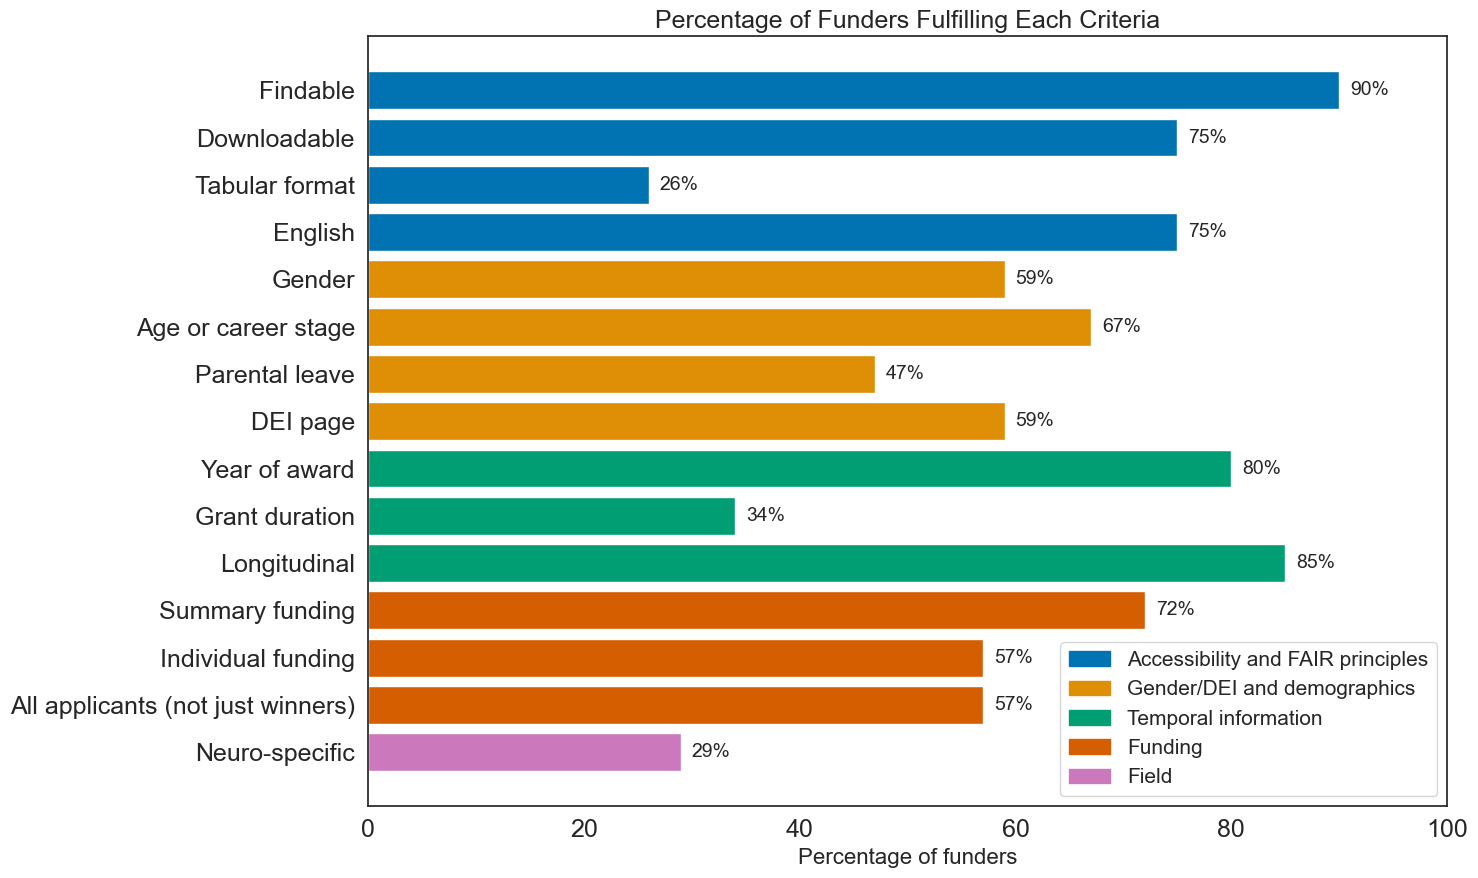

In [12]:
# Drop rows without labels (those are not in the scale)
percentages_df = percentages_df.dropna(subset=['Measure_Label']).copy()

# Get the seaborn colorblind palette
palette = sns.color_palette("colorblind", n_colors=5)

# Map categories to palette colors
category_colors = {
    "Accessibility and FAIR principles": palette[0],
    "Gender/DEI and demographics": palette[1],
    "Temporal information": palette[2],
    "Funding": palette[3],
    "Field": palette[4],
}

# Plot
df_plot = percentages_df.iloc[::-1] # reverse the order so it plots correctly
colors_list = [category_colors.get(cat, "gray") for cat in df_plot['Category']]

plt.figure(figsize=(15, 9))
bars = plt.barh(df_plot["Measure_Label"], df_plot["Percent_of_Funders"], color=colors_list)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.0f}%", va='center')

plt.xlabel("Percentage of funders")
plt.title("Percentage of Funders Fulfilling Each Criteria")
plt.xlim(0, 100)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

handles = [plt.Rectangle((0,0),1,1,color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), fontsize=15)

plt.tight_layout()
plt.savefig(figures_p / "Figure1.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# Get the frequency of each data type (not just max per funder)
data_type_counts = funders['data_type'].value_counts().reset_index()
data_type_counts.columns = ['data_type', 'count']

# Calculate percentages
data_type_counts['percentage'] = ((data_type_counts['count'] / data_type_counts['count'].sum()) * 100).round(0).astype(int)
data_type_counts


,data_type,count,percentage
0,annual_report,19,36
1,tabular,13,25
2,portal,10,19
3,report,6,11
4,list,5,9


In [14]:
# Calculate the widest range of data available per funder
# Extract start and end of funding years
funders[["start_year", "end_year"]] = (funders["dates_covered"].apply(extract_years).apply(pd.Series)) 
funders["start_year"] = funders["start_year"].astype("Int64") 
funders["end_year"] = funders["end_year"].astype("Int64") 
funders.sort_values("start_year").head()

,checked since 09/2025,researcher,category,country,funder,label,data_type,dates_covered,findable,data_downloadable,...,total_score,age,career_stage,disability,ethnicity,osf_file,notes,clean_label,start_year,end_year
13,Y,NC,EU member,Denmark,Novo Nordisk Foundation,DK - Novo Nordisk Foundation (NNF),portal,1963-2025,1,0.0,...,6,0.0,0.0,0.0,0.0,NaN,NaN,DK - Novo Nordisk Foundation (NNF),1963,2025
54,Y,DP,Schengen area,Switzerland,SNSF,CH - Swiss National Science Foundation (SNSF),tabular,1974-2025,1,1.0,...,13,0.0,1.0,0.0,0.0,/Switzerland - SNSF/All_grants.csv,NaN,CH - Swiss National Science Foundation (SNSF),1974,2025
31,Y,DP,EU member,Netherlands,NWO,NL - Dutch Research Council (NWO),portal,1993-2025,1,0.0,...,7,0.0,0.0,0.0,0.0,Projectendatabank | NWO,NaN,NL - Dutch Research Council (NWO),1993,2025
0,Y,PM,EU member,Austria,FWF,AT - Austrian Science Fund (FWF),tabular,1995-2025,1,1.0,...,11,0.0,1.0,0.0,0.0,/Austria - FWF/PI-projects....csv + annual rep...,NaN,AT - Austrian Science Fund (FWF),1995,2025
24,Y,PM,EU member,Italy,Ministry of University and Research (MUR),IT - Ministry of University and Research (MUR),list,1999-2022,1,1.0,...,10,0.0,1.0,0.0,0.0,"N/A, list online (see https://prin.mur.gov.it/)",NaN,IT - Ministry of University and Research (MUR),1999,2022


In [15]:
# Drop rows with no years
years_df = funders.dropna(subset=["start_year"]).copy()

# Create the range of years for each funder
years_df["years_range"] = years_df.apply(lambda row: list(range(int(row["start_year"]), int(row["end_year"]) + 1)), axis=1)

# Expand into one row per year
years_df = years_df.explode("years_range").rename(columns={"years_range": "year"})

# Count unique funders per year
yearly_counts = years_df.groupby("year")["label"].nunique().reset_index()

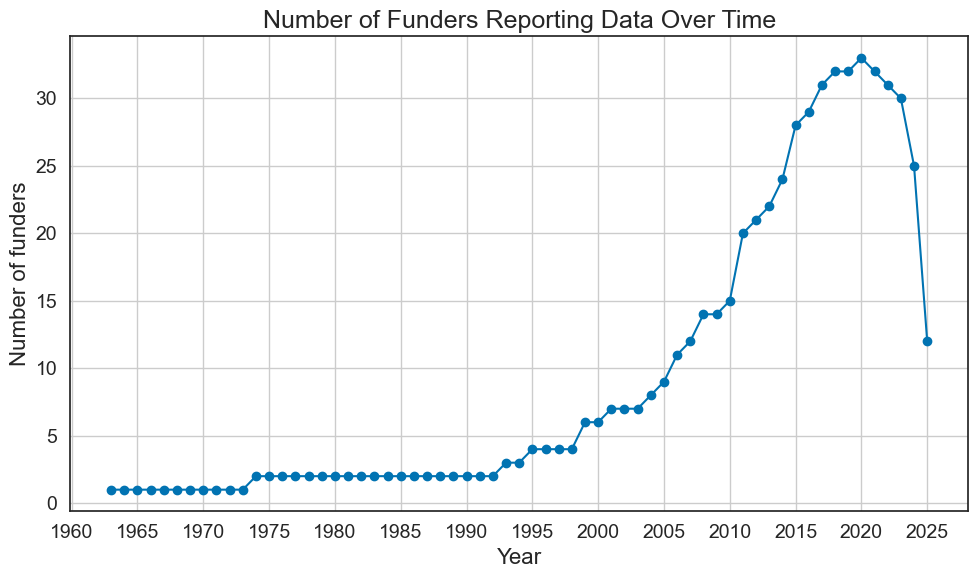

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["year"], yearly_counts["label"], marker="o")
plt.title("Number of Funders Reporting Data Over Time")
plt.xlabel("Year")
plt.ylabel("Number of funders")
plt.grid(True)
plt.xticks(ticks=range(1960, 2026, 5))
plt.tight_layout()
plt.savefig(figures_p / "Figure2.jpg",dpi=300)
plt.show()

In [17]:
funders_per_country = funders.groupby('country')['label'].nunique().reset_index() 
funders_per_country.columns = ['country', 'num_funders'] 
funders_per_country['country'] = funders_per_country['country'].replace('UK', 'United Kingdom') 
funders_per_country.head()

,country,num_funders
0,Austria,1
1,Belgium,2
2,Bulgaria,1
3,Croatia,1
4,Czech Republic,1


In [18]:
# How much data is donwloaded?
downloadable = funders[funders["data_downloadable"] == 1].copy()

# Number of data records
num_records = len(downloadable)

# Number of unique funders with downloadable data
num_funders = downloadable["label"].nunique()

# Number of unique countries with downloadable data
num_countries = downloadable["country"].nunique()

num_records, num_funders, num_countries

(43, 29, 25)

In [19]:
# Earliest start year and latest end year
earliest_start = downloadable["start_year"].min()
latest_end = downloadable["end_year"].max()

print(f"Earliest start year: {earliest_start}")
print(f"Latest end year: {latest_end}")

Earliest start year: 1974
Latest end year: 2025


In [20]:
# keep only the row with the highest total_score per funder. Here we include Liechtenstein, just to show them on the plot
best_df = df.sort_values("total_score", ascending=False).drop_duplicates("label")
best_df = best_df.sort_values("total_score").dropna(subset=["label"])

# assign colors
best_df["color"] = best_df["total_score"].apply(tier_color)

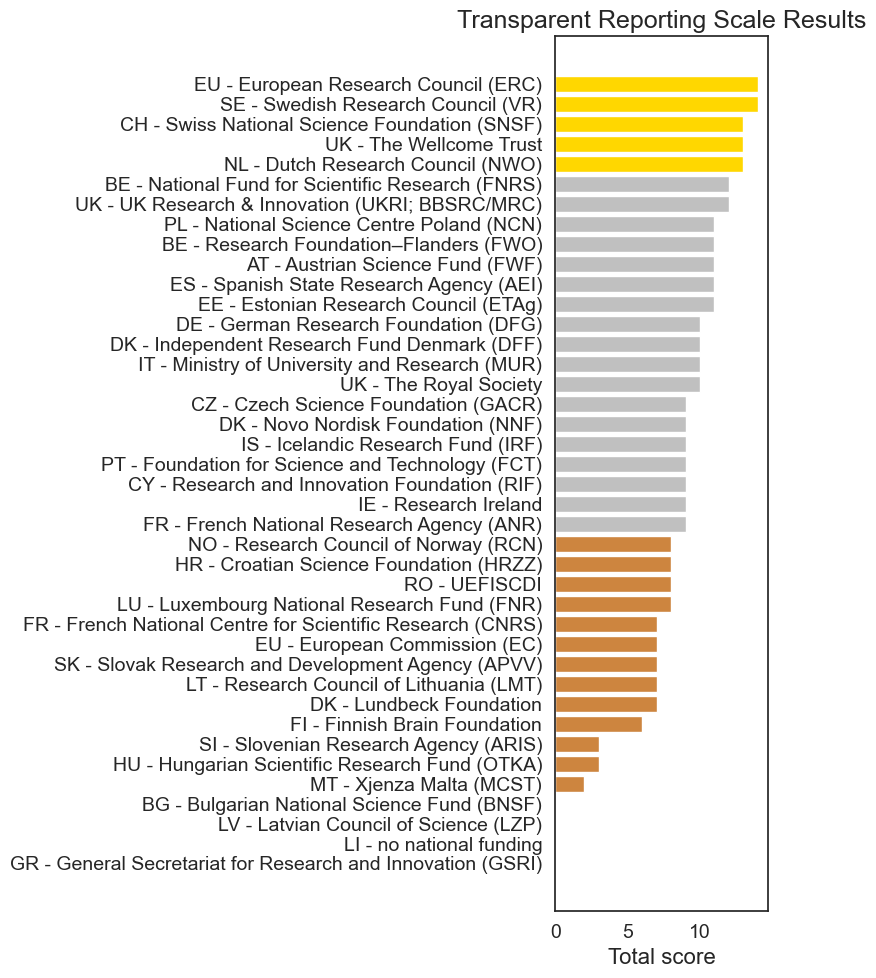

In [21]:
plt.figure(figsize=(8, 10))
plt.barh(
    best_df["label"].astype(str),
    best_df["total_score"],
    color=best_df["color"]
)

plt.xlabel("Total score")
plt.title("Transparent Reporting Scale Results")
plt.tight_layout()
plt.savefig(figures_p / "Figure3.jpg",dpi=300, bbox_inches="tight")
plt.show()

# Calculate correlation between TRS scores, and GEI and GDP

In [22]:
gei_df.head()

,Time,Geographic region,Value,(Sub-) Domain Scores
0,2025,Austria,76.9,Attainment and participation (Subdomain score)
1,2025,Austria,53.2,Care activities (Subdomain score)
2,2025,Austria,50.6,Economic power (Subdomain score)
3,2025,Austria,64.6,Economic situation (Subdomain score)
4,2025,Austria,66.0,Financial resources (Subdomain score)


In [23]:
countries = wb.get_countries()
european_countries = countries[countries['region'] == 'Europe']
#print(european_countries.columns)

In [24]:
# GDP per capita (current USD)
gdp_series = wb.get_series(
    'NY.GDP.PCAP.CD',       # Indicator code for GDP per capita
    country=european_countries['iso2Code'].tolist(),
    date='2024', # This is the latest available
    simplify_index=True   
)
gdp_df = gdp_series.reset_index()
gdp_df.columns = ['Country', 'GDP_per_capita_USD']
print(gdp_df.head())

                          Country  GDP_per_capita_USD
0     Africa Eastern and Southern         1615.396356
1      Africa Western and Central         1411.337029
2                      Arab World         7583.811701
3          Caribbean small states        19903.811231
4  Central Europe and the Baltics        24604.806860


In [25]:
best_df['country_clean'] = best_df['country'].str.strip("'")

# For World Bank GDP
gdp_name_map = {
    'Slovakia': 'Slovak Republic',
    'UK': 'United Kingdom',
    'Czech Republic': 'Czechia',
    'Republic of Cyprus': 'Cyprus'
}

best_df['country_gdp'] = best_df['country_clean'].replace(gdp_name_map)

In [26]:
# GDP merge
df_merged = pd.merge(
    best_df,
    gdp_df[['Country', 'GDP_per_capita_USD']],
    left_on='country_gdp',
    right_on='Country',
    how='left')

# GEI merge
gei_overall_df = gei_df[gei_df["(Sub-) Domain Scores"] == "Overall Gender Equality Index"]

df_merged = pd.merge(
    df_merged,
    gei_overall_df[['Geographic region', 'Value']],
    left_on='country_clean',
    right_on='Geographic region',
    how='left')

In [27]:
# Take the maximum scoring funder per country
max_idx = df_merged.groupby('country_clean')['total_score'].idxmax()
df_max = df_merged.loc[max_idx,['country_clean', 'total_score', 'GDP_per_capita_USD', 'Value', 'color']].reset_index(drop=True)

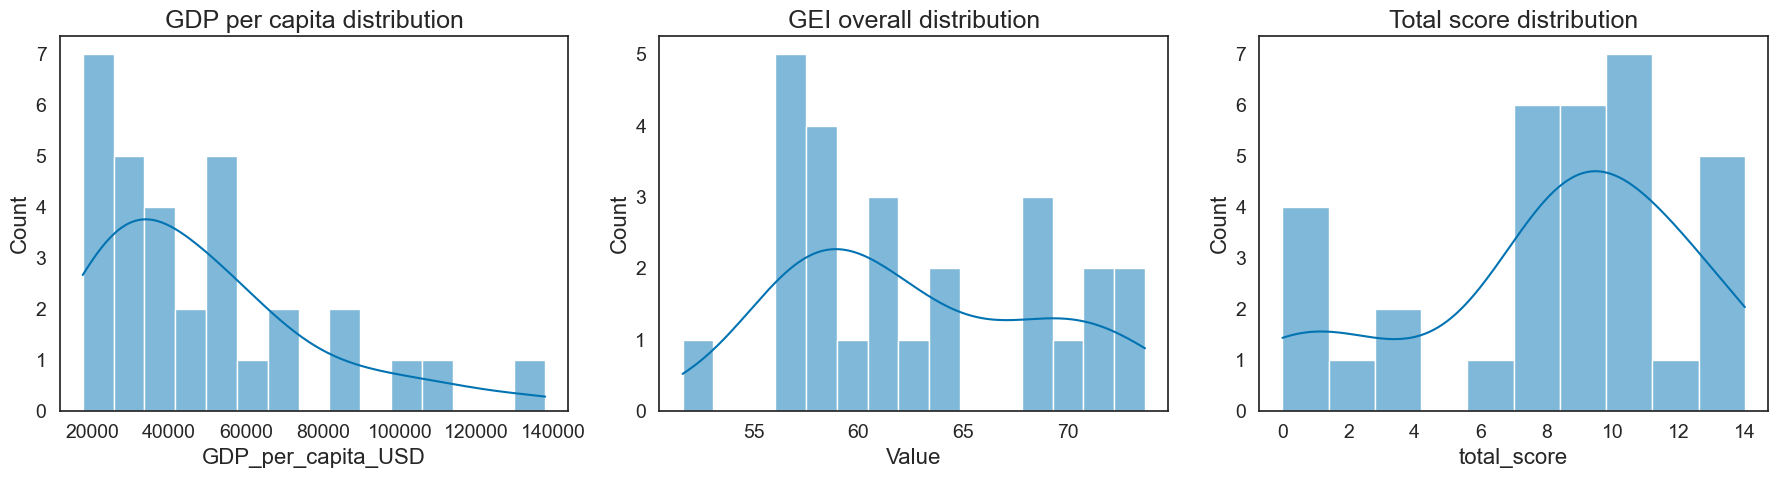

GDP per capita distribution: W=0.860, p=0.001
GEI overall distribution: W=0.922, p=0.057
Total score distribution: W=0.899, p=0.005


In [28]:
# Check normality 
columns = ["GDP_per_capita_USD", "Value", "total_score"]
titles = ["GDP per capita distribution", "GEI overall distribution", "Total score distribution"]

plt.figure(figsize=(18,5))

for i, col in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_max[col], kde=True, bins=15 if col!="total_score" else 10)
    plt.title(titles[i-1])

plt.tight_layout()
plt.show()

# Shapiro-Wilk test
for col, title in zip(columns, titles):
    shapiro_df = df_max[[col]].dropna()
    stat, p = stats.shapiro(shapiro_df[col])
    print(f"{title}: W={stat:.3f}, p={p:.3f}")

In [29]:
# List of predictors to correlate with total_score
predictors = ["GDP_per_capita_USD", "Value"]

for var in predictors:
    rho, ci_low, ci_high, p, n = spearman_ci(df_max, var, "total_score")
    print(f"{var}: Spearman rho={rho:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p={p:.3f}, n={n}")

GDP_per_capita_USD: Spearman rho=0.514, 95% CI [0.196, 0.735], p=0.003, n=31
Value: Spearman rho=0.642, 95% CI [0.330, 0.827], p=0.001, n=25


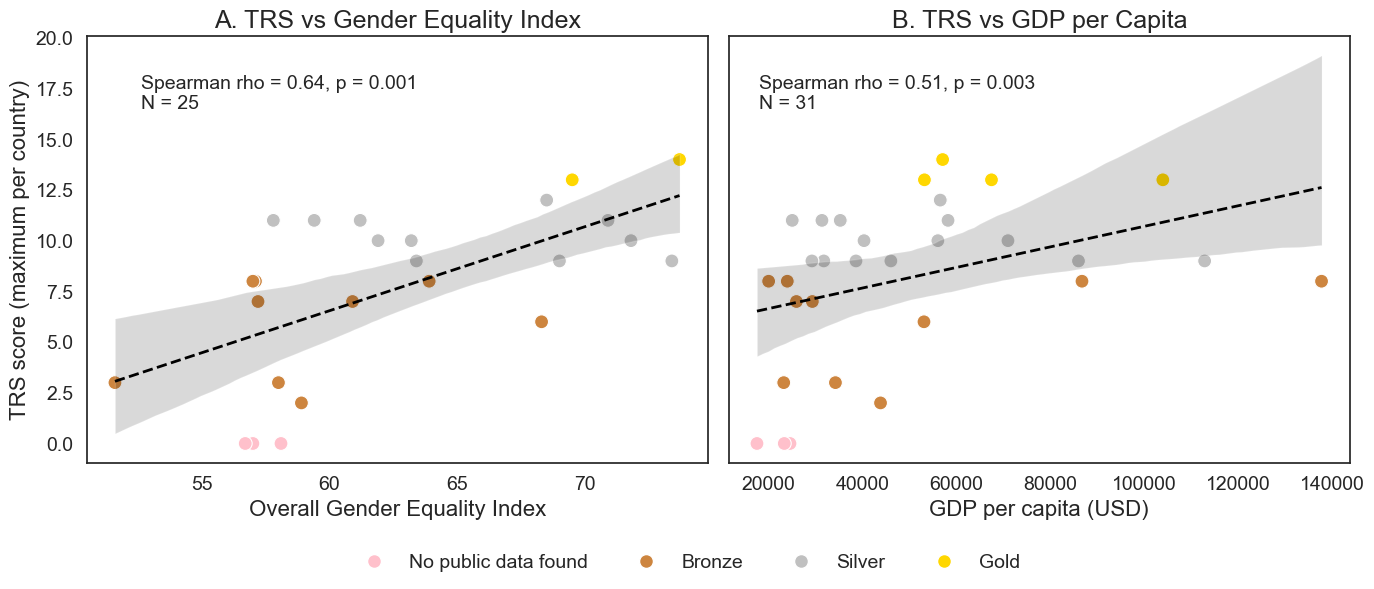

In [30]:
# Generate figure
palette_dict = {
    'pink': 'pink',
    'peru': 'peru',
    'silver': 'silver',
    'gold': 'gold'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# -------- Panel A: GEI --------
sns.scatterplot(
    ax=axes[0],
    x='Value',
    y='total_score',
    data=df_max,
    hue='color',
    palette=palette_dict,
    s=100,
    legend=False
)

sns.regplot(
    ax=axes[0],
    x='Value',
    y='total_score',
    data=df_max,
    scatter=False,
    line_kws={'color': 'black', 'lw': 2, 'ls': '--'}
)

rho_gei, _, _, p_gei, n_gei = spearman_ci(df_max, "Value", "total_score")
axes[0].text(
    df_max["Value"].min()*1.02,
    df_max["total_score"].max()*1.3,
    f"Spearman rho = {rho_gei:.2f}, p = {p_gei:.3f}\nN = {n_gei}",
    fontsize=14,
    ha='left',
    va='top',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

axes[0].set_xlabel('Overall Gender Equality Index')
axes[0].set_ylabel('TRS score (maximum per country)')
axes[0].set_title('A. TRS vs Gender Equality Index')

# -------- Panel B: GDP --------
sns.scatterplot(
    ax=axes[1],
    x='GDP_per_capita_USD',
    y='total_score',
    data=df_max,
    hue='color',
    palette=palette_dict,
    s=100,
    legend=False
)

sns.regplot(
    ax=axes[1],
    x='GDP_per_capita_USD',
    y='total_score',
    data=df_max,
    scatter=False,
    line_kws={'color': 'black', 'lw': 2, 'ls': '--'}
)

rho_gdp, _, _, p_gdp, n_gdp = spearman_ci(df_max, "GDP_per_capita_USD", "total_score")
axes[1].text(
    df_max["GDP_per_capita_USD"].min()*1.02,
    df_max["total_score"].max()*1.3,
    f"Spearman rho = {rho_gdp:.2f}, p = {p_gdp:.3f}\nN = {n_gdp}",
    fontsize=14,
    ha='left',
    va='top',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

axes[1].set_xlabel('GDP per capita (USD)')
axes[1].set_title('B. TRS vs GDP per Capita')

# -------- Shared legend --------
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10,
           label='No public data found'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='peru', markersize=10,
           label='Bronze'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='silver', markersize=10,
           label='Silver'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10,
           label='Gold')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=4,
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig(figures_p / "Figure4.jpg", dpi=300)
plt.show()

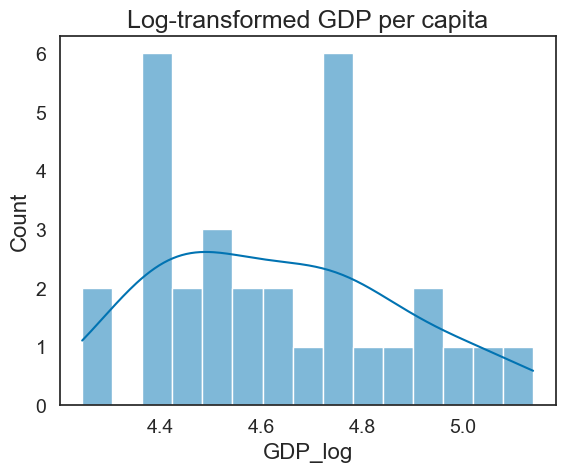

Value: Spearman rho=0.514, 95% CI [0.196, 0.735], p=0.003, n=31


In [31]:
# Try with log transforming GDP data
df_max['GDP_log'] = np.log10(df_max['GDP_per_capita_USD'])
sns.histplot(df_max['GDP_log'], kde=True, bins=15)
plt.title("Log-transformed GDP per capita")
plt.show()

rho_log, ci_low_log, ci_high_log, p_log, n_log = spearman_ci(df_max, 'GDP_log', "total_score")
print(f"{var}: Spearman rho={rho_log:.3f}, 95% CI [{ci_low_log:.3f}, {ci_high_log:.3f}], p={p_log:.3f}, n={n_log}")

In [32]:
# Try with minimum score per country, instead of max
min_idx = df_merged.groupby('country_clean')['total_score'].idxmin()
df_min = df_merged.loc[min_idx, ['country_clean', 'total_score', 'GDP_per_capita_USD','Value', 'color']].reset_index(drop=True)

In [33]:
for var in predictors:
    rho, ci_low, ci_high, p, n = spearman_ci(df_min, var, "total_score")
    print(f"{var}: Spearman rho={rho:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p={p:.3f}, n={n}")

GDP_per_capita_USD: Spearman rho=0.454, 95% CI [0.118, 0.696], p=0.010, n=31
Value: Spearman rho=0.523, 95% CI [0.162, 0.761], p=0.007, n=25


In [34]:
# And the mean
df_mean = df_merged.groupby('country', as_index=False).agg(
    total_score=('total_score', 'mean'),        # average TRS score per country
    GDP_per_capita_USD=('GDP_per_capita_USD', 'first'),
    Value=('Value', 'first'))

In [35]:
for var in predictors:
    rho, ci_low, ci_high, p, n = spearman_ci(df_mean, var, "total_score")
    print(f"{var}: Spearman rho={rho:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p={p:.3f}, n={n}")

GDP_per_capita_USD: Spearman rho=0.498, 95% CI [0.174, 0.724], p=0.004, n=31
Value: Spearman rho=0.605, 95% CI [0.275, 0.807], p=0.001, n=25
